# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets. 

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English. 

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text. 

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np

Let's get the data!

In [2]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Initialize the tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on the corpus
tokenizer.fit_on_texts(corpus)

Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [4]:
# Calculate the vocabulary size
total_words = len(tokenizer.word_index) + 1
print(f"Vocabulary Size: {total_words}")

Vocabulary Size: 3375


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [5]:
# Create input sequences
input_sequences = []

for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

print(f"Total sequences generated: {len(input_sequences)}")

Total sequences generated: 15484


Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Calculate the length of the longest sequence
max_sequence_len = max(len(seq) for seq in input_sequences)

# Pad the sequences
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

# Convert to numpy array
input_sequences = np.array(input_sequences)

print(f"Padded Sequences Shape: {input_sequences.shape}")

Padded Sequences Shape: (15484, 11)


Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [7]:
# Split sequences into predictors (X) and labels (y)
X = input_sequences[:, :-1]  # All elements except the last one
y = input_sequences[:, -1]   # The last element of each sequence

print(f"Predictors Shape: {X.shape}")
print(f"Labels Shape: {y.shape}")

Predictors Shape: (15484, 10)
Labels Shape: (15484,)


One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors. 

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [8]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
y = to_categorical(y, num_classes=total_words)

print(f"One-Hot Encoded Labels Shape: {y.shape}")

One-Hot Encoded Labels Shape: (15484, 3375)


# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2

# Initialize the model
model = Sequential([
    Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len - 1),
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.2),
    LSTM(100),
    Dense(total_words // 2, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(total_words, activation='softmax')
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [10]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [11]:
# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [12]:
# Train the model
history = model.fit(X, y, epochs=50, verbose=1)

Epoch 1/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.0197 - loss: 7.3407
Epoch 2/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.0211 - loss: 6.4877
Epoch 3/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.0231 - loss: 6.3935
Epoch 4/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.0297 - loss: 6.2708
Epoch 5/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.0339 - loss: 6.2252
Epoch 6/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.0344 - loss: 6.1467
Epoch 7/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.0419 - loss: 6.0237
Epoch 8/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.0444 - loss: 5.9756
Epoch 9/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.0435 - loss: 5.9175
Epoch 10/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.0477 - loss: 5.8143
Epoch 11/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.0559 - loss: 5.6932
Epoch 12/50
484/484 ━━━━━━━━━━

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

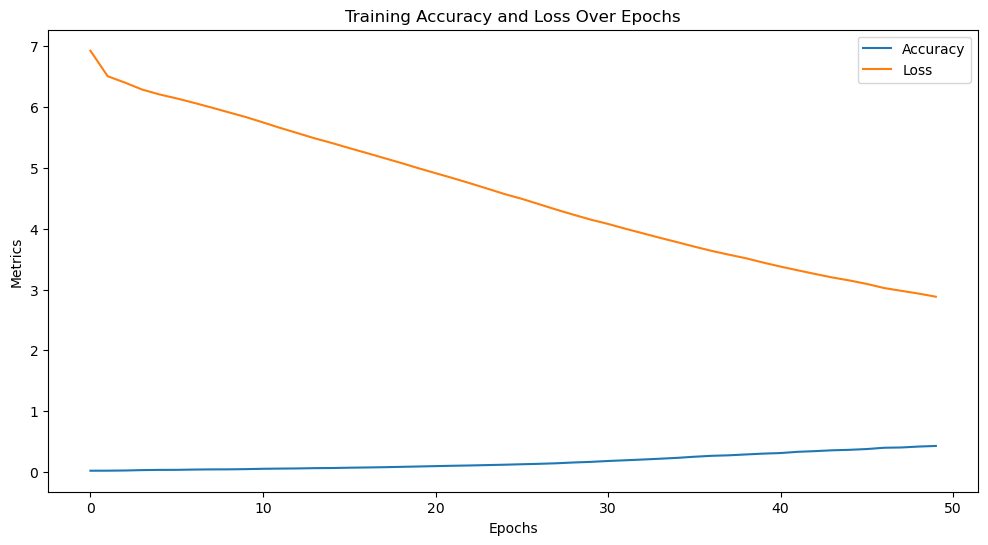

In [13]:
import matplotlib.pyplot as plt

# Plot training accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training Accuracy and Loss Over Epochs')
plt.legend()
plt.show()

# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [14]:
# Define seed text and number of words to generate
seed_text = "Write the text you want the model to use as a starting point to generate the next words"
next_words = 50  # Adjust as needed

# Generate text
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    next_word_index = predicted.argmax()
    next_word = tokenizer.index_word[next_word_index]
    seed_text += " " + next_word

print(seed_text)

Write the text you want the model to use as a starting point to generate the next words hate night days night days tell days days night night time time night of age night of store of loss to men night night night of night night hours of loss of your love being used of decay now ' now me done be thee did ill ' are be


Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [15]:
# Experiment with different seed texts
seed_texts = [
    "The beauty of the sunset",
    "Once upon a midnight dreary",
    "In the world of dreams"
]

# Generate text for each seed text
for seed_text in seed_texts:
    print(f"Seed Text: {seed_text}")
    generated_text = seed_text
    for _ in range(50):  # Generate 50 words for each seed
        token_list = tokenizer.texts_to_sequences([generated_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        next_word_index = predicted.argmax()
        next_word = tokenizer.index_word[next_word_index]
        generated_text += " " + next_word
    print(f"Generated Text: {generated_text}\n")

Seed Text: The beauty of the sunset
Generated Text: The beauty of the sunset knife eyes it forgot well prove me new ' new ' fall and his sight of show me dead express'd grow ' ' lies be thee bright me ' are know ' now to thee old lie to me me me ' ' be be free ' ' tell that

Seed Text: Once upon a midnight dreary
Generated Text: Once upon a midnight dreary bastard hymns did hush to loss new me thee me those contents great shade grow still ' dead men ' ' are be be art tend write to write me still men art men days grow new tell that mine eye lies not still me thee thee last so art

Seed Text: In the world of dreams
Generated Text: In the world of dreams which you did gone now me me so foes tomb thee thee thee done thee thee last so bright life to words men 'will of ill best days grow night of less stay men night night child of loss to thee mine tell the time i sing bright of thee



Experiment with at least 3 different seed_text strings and see what happens!

In [16]:
# Your code here :